In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats

In [2]:
# Load in Datasets - prefiltered to only include relevant rows
free_int = pd.read_csv("https://stanford-school-enrollment-project.datasette.io/schools/enrollments.csv?_stream=on&_sort=rowid&free_and_reduced_int__notblank=1&_size=max", low_memory=False) 
free_percent = pd.read_csv('https://stanford-school-enrollment-project.datasette.io/schools/enrollments.csv?_stream=on&_sort=rowid&free_and_reduced_percent__notblank=1&_size=max', low_memory=False)



In [3]:
# convert data to numeric values
free_percent['free_and_reduced_percent'] = free_percent['free_and_reduced_percent'].apply(
    lambda x: float(x[1:]) if '>' in x else float(x))

In [4]:
# add percentage values
free_int['free_and_reduced_percent'] = free_int['free_and_reduced_int'] / free_int['total_int'] * 100

In [5]:
# add integer values
free_percent['free_and_reduced_int'] = free_percent['free_and_reduced_percent'] * free_percent['total_int'] / 100

In [6]:
# create combined dataframe
combined = pd.concat([free_int, free_percent], ignore_index=True)

In [7]:
# preview shape of dataframe (112230 rows, 70 columns)
combined.shape

(112230, 70)

In [8]:
# preview all columns in dataframe
combined.columns

Index(['rowid', 'state', 'county', 'county_state_id', 'admin_level',
       'district_nces_id', 'district_state_id', 'district_state_type',
       'district', 'school_nces_id', 'school_state_id', 'school',
       'school_state_type', 'ccd_school_type', 'ccd_charter_school',
       'ccd_school_lvl', 'ccd_school_low_grade', 'ccd_school_high_grade',
       'year', 'term', 'grade', 'white', 'black', 'hispanic',
       'native_american', 'native_american_alaskan_native', 'asian',
       'native_hawaiian', 'asian_pacific_islander',
       'native_hawaiian_pacific_islander', 'pacific_islander', 'multiracial',
       'unknown_race', 'male', 'female', 'non_binary', 'unknown_gender', 'ell',
       'ell_percent', 'homeless', 'homeless_percent', 'low_income',
       'free_and_reduced', 'free_and_reduced_percent', 'disability',
       'section_504', 'total', 'white_int', 'black_int', 'hispanic_int',
       'native_american_int', 'native_american_alaskan_native_int',
       'asian_int', 'native_hawa

In [9]:
# filter dataframe to only include relevant columns for future EDA and analysis
df = combined[['state', 'county', 'school', 'ccd_school_low_grade', 'ccd_school_high_grade', 'year', 'grade',
               'free_and_reduced_percent', 'white_int', 'black_int', 'hispanic_int',
       'native_american_int', 'native_american_alaskan_native_int',
       'asian_int', 'native_hawaiian_int', 'asian_pacific_islander_int',
       'native_hawaiian_pacific_islander_int', 'pacific_islander_int',
       'multiracial_int', 'unknown_race_int', 'male_int', 'female_int',
       'non_binary_int', 'unknown_gender_int', 'ell_int', 'homeless_int',
       'low_income_int', 'free_and_reduced_int', 'disability_int',
       'section_504_int', 'total_int']]

In [10]:
df['state'].value_counts()

state
MN    68931
CA    21133
MO     9701
IN     7458
NJ     5007
Name: count, dtype: int64

In [12]:
# cap percentages at 100%
df['free_and_reduced_percent'] = df['free_and_reduced_percent'].apply(lambda x: 100 if x > 100 else x)

In [13]:
# add percentage values for each race
df['black_percent'] = df['black_int'] / df['total_int'] * 100
df['white_percent'] = df['white_int'] / df['total_int'] * 100
df['hispanic_percent'] = df['hispanic_int'] / df['total_int'] * 100
df['aapi_percent'] = (df['asian_int'] + df['asian_pacific_islander_int'] + 
                      df['pacific_islander_int']) / df['total_int'] * 100
df['native_percent'] = (df['native_american_int'] + df['native_american_alaskan_native_int'] + 
                      df['native_hawaiian_int'] + df['native_hawaiian_pacific_islander_int']) / df['total_int'] * 100

In [14]:
# Create a DataFrame 'percentages' that contains the percentage of each race for each school
percentages = df[['white_percent', 'black_percent', 'hispanic_percent']]
# Create a new column 'majority_race' that contains the race with the highest percentage for each school
df['majority_race'] = percentages.idxmax(axis=1)


In [15]:
# split dataframes into pre and post covid
pre_covid = df[df['year'] < 2020]
post_covid = df[df['year'] >= 2020]

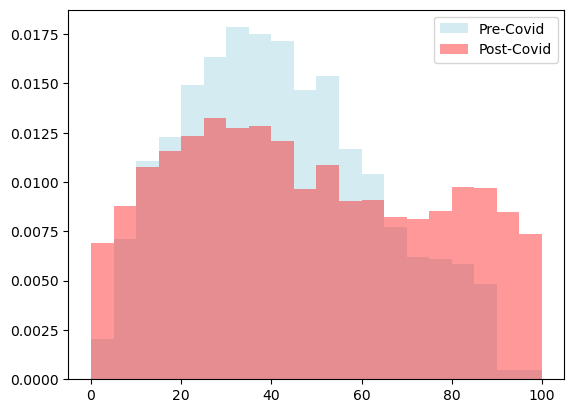

In [21]:
# plot histogram of free and reduced lunch rates pre and post covid
plt.hist(pre_covid['free_and_reduced_percent'], bins=20, alpha = 0.5, color="lightblue", density=True, label='Pre-Covid')
plt.hist(post_covid['free_and_reduced_percent'], bins=20, alpha = 0.4, color="red", density=True, label='Post-Covid')
plt.legend()

In [42]:
# run ks hypothesis test to see if distributions of free and reduced lunches are different pre and post covid
result = stats.kstest(pre_covid['free_and_reduced_percent'], post_covid['free_and_reduced_percent'])
if result.pvalue < 0.05:
    print(f'p-value = {result.pvalue}, so Reject H0 at level {0.05}')  
else:
    print(f'p-value = {result.pvalue}, so Fail to Reject H0 at level {0.05}')

p-value = 0.0, so Reject H0 at level 0.05


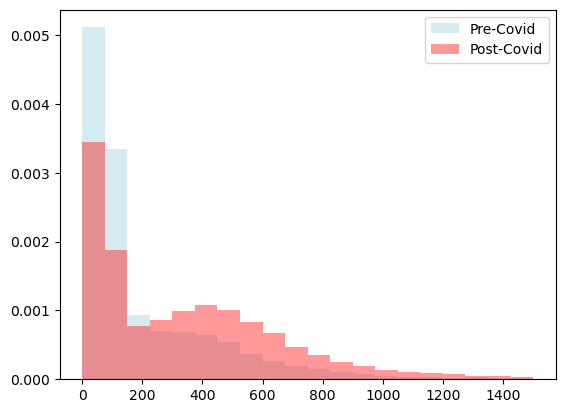

In [23]:
# plot histogram of enrollment distributions pre and post covid
plt.hist(pre_covid['total_int'], bins=20, alpha = 0.5, color="lightblue", density=True, range=(0,1500), label='Pre-Covid')
plt.hist(post_covid['total_int'], bins=20, alpha = 0.4, color="red", density=True, range=(0,1500), label='Post-Covid')
plt.legend()

In [44]:
# run ks hypothesis test to see if distributions of total enrollment are different pre and post covid
result = stats.kstest(pre_covid['total_int'], post_covid['total_int'])
if result.pvalue < 0.05:
    print(f'p-value = {result.pvalue}, so Reject H0 at level {0.05}')  
else:
    print(f'p-value = {result.pvalue}, so Fail to Reject H0 at level {0.05}')

p-value = 0.0, so Reject H0 at level 0.05


<Axes: >

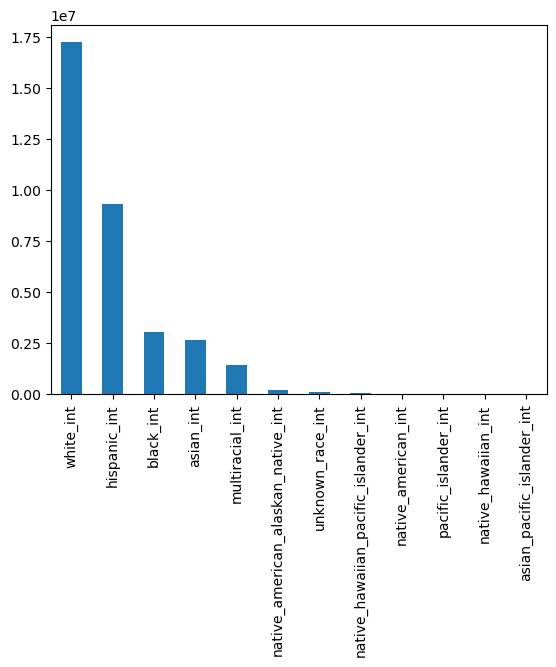

In [45]:
# top three races by enrollment
df[['white_int', 'black_int', 'hispanic_int',
       'native_american_int', 'native_american_alaskan_native_int',
       'asian_int', 'native_hawaiian_int', 'asian_pacific_islander_int',
       'native_hawaiian_pacific_islander_int', 'pacific_islander_int',
       'multiracial_int', 'unknown_race_int']].sum(axis=0).sort_values(ascending=False).plot(kind='bar')

In [101]:
# chi-squared test to compare distributions of three most common races before and after covid
result = stats.chisquare(np.array(pre_covid[['white_int', 'hispanic_int', 'black_int']].sum()) / sum(list(pre_covid[['white_int', 'hispanic_int', 'black_int']].sum())),
                np.array(post_covid[['white_int', 'hispanic_int', 'black_int']].sum()) / sum(list(post_covid[['white_int', 'hispanic_int', 'black_int']].sum())), ddof=0, axis=0)
result.pvalue


0.7506250946270197

For the following data visualizations, using the full dataset results in difficult to view the plots, so we will use a random sample of 1000 points for ease of understanding.

In [83]:
# create sample datasets
pre_sample = pre_covid.sample(n=500, random_state=2)
post_sample = post_covid.sample(n=500, random_state=2)

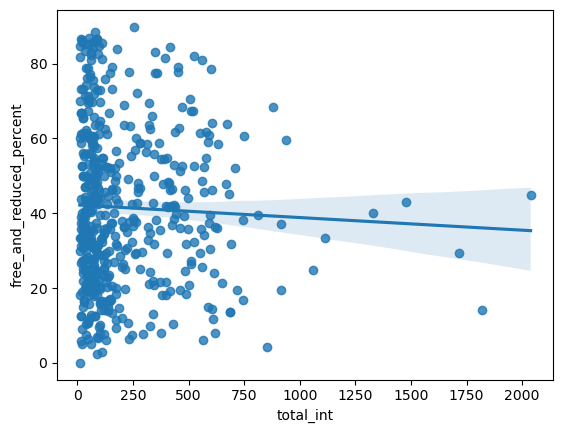

In [79]:
# school size vs free and reduced lunch rate pre-covid
ax = sns.regplot(data=pre_sample, x="total_int", y="free_and_reduced_percent")


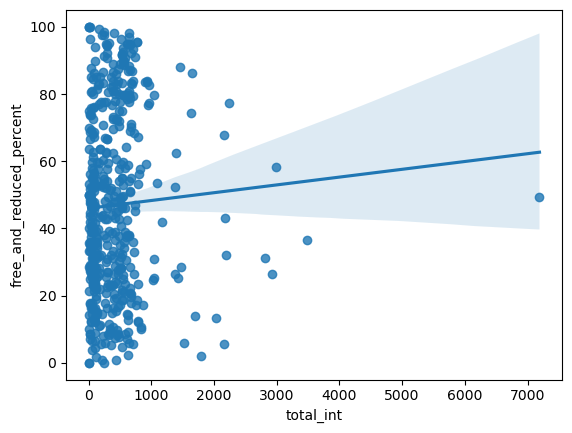

In [78]:
# school size vs free and reduced lunch rate post-covid
ax = sns.regplot(data=post_sample, x="total_int", y="free_and_reduced_percent")

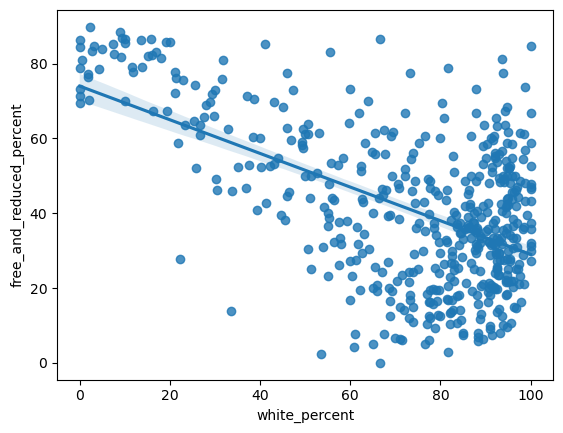

In [49]:
# percentage of white students vs free and reduced lunch rate pre-covid
ax = sns.regplot(data=pre_sample, x="white_percent", y="free_and_reduced_percent")

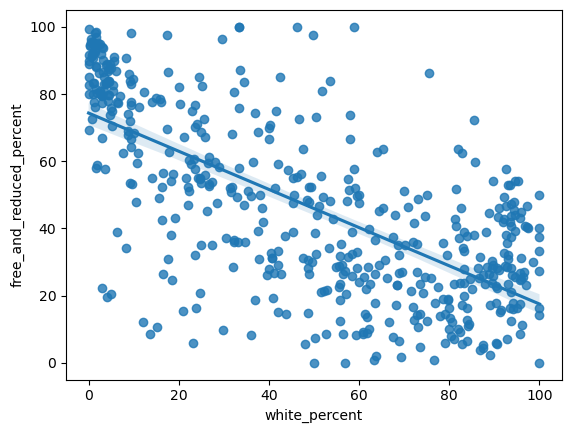

In [50]:
# percentage of white students vs free and reduced lunch rate post-covid
ax = sns.regplot(data=post_sample, x="white_percent", y="free_and_reduced_percent")

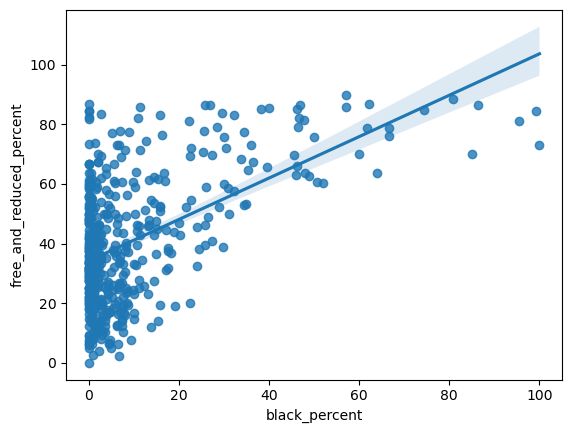

In [51]:
# percentage of black students vs free and reduced lunch rate pre-covid
ax = sns.regplot(data=pre_sample, x="black_percent", y="free_and_reduced_percent")

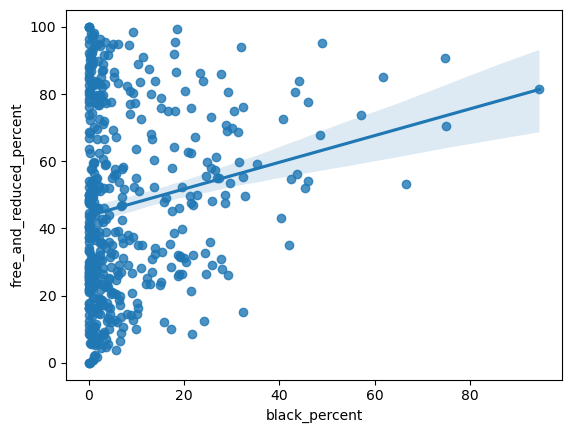

In [52]:
# percentage of black students vs free and reduced lunch rate post-covid
ax = sns.regplot(data=post_sample, x="black_percent", y="free_and_reduced_percent")

## ANALYSIS

## General Linear Regression Coefficients

In [27]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

before_covid_data = pre_covid
after_covid_data = post_covid

before_covid_X = before_covid_data[["free_and_reduced_percent"]]
before_covid_X = sm.add_constant(before_covid_X)

before_covid_y = before_covid_data["total_int"]


after_covid_X = after_covid_data[["free_and_reduced_percent"]]
after_covid_X = sm.add_constant(after_covid_X)
after_covid_y = after_covid_data["total_int"]

model_before = sm.OLS(before_covid_y, before_covid_X).fit()
model_after = sm.OLS(after_covid_y, after_covid_X).fit()



print(f"model before covid [2016-2019]: {model_before.summary()}")
print(f"model after covid [2020-2021]: {model_after.summary()}")


model before covid [2016-2019]:                             OLS Regression Results                            
Dep. Variable:              total_int   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     318.6
Date:                Fri, 08 Mar 2024   Prob (F-statistic):           4.52e-71
Time:                        14:49:03   Log-Likelihood:            -4.3040e+05
No. Observations:               60448   AIC:                         8.608e+05
Df Residuals:                   60446   BIC:                         8.608e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [28]:
CI_before= model_before.conf_int()
CI_before

,0,1
const,258.005851,268.606196
free_and_reduced_percent,-1.139104,-0.913681


In [29]:
CI_after= model_after.conf_int()
CI_after

,0,1
const,325.409059,341.660037
free_and_reduced_percent,1.303238,1.598471


In [30]:
print(f"The confidence interval for the difference between 'free_and_reduced_percent' after and before covid is: {(CI_after[0][1]-CI_before[1][1]).item(), (CI_after[1][1]-CI_before[0][1]).item()}")

The confidence interval for the difference between 'free_and_reduced_percent' after and before covid is: (2.2169188731526064, 2.7375753664158733)


## Linear Regression for Top 3 Majority Races

<Axes: >

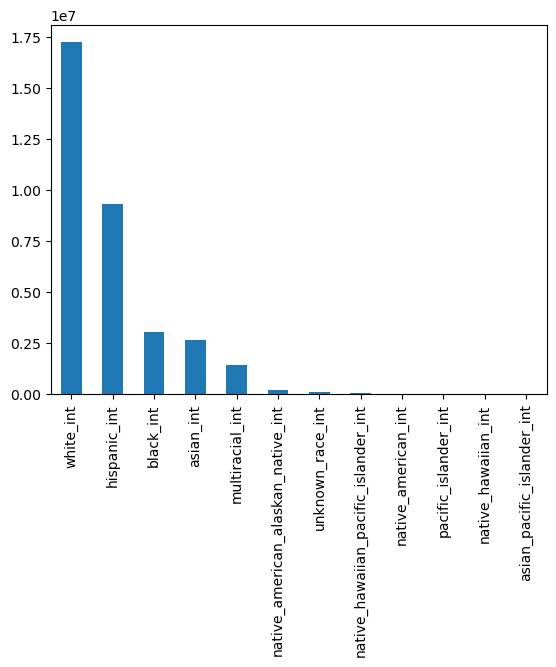

In [38]:
# As a reminder, the three most common races in the dataset are white, hispanic, and black
df[['white_int', 'black_int', 'hispanic_int',
       'native_american_int', 'native_american_alaskan_native_int',
       'asian_int', 'native_hawaiian_int', 'asian_pacific_islander_int',
       'native_hawaiian_pacific_islander_int', 'pacific_islander_int',
       'multiracial_int', 'unknown_race_int']].sum(axis=0).sort_values(ascending=False).plot(kind='bar')

In [53]:
## Linear Regression for majority race = white
before_covid_data_white = pre_covid[pre_covid['majority_race'] == 'white_percent']
after_covid_data_white = post_covid[post_covid['majority_race'] == 'white_percent']

before_covid_X_white = before_covid_data_white[["free_and_reduced_percent"]]
before_covid_X_white = sm.add_constant(before_covid_X_white)
before_covid_y_white = before_covid_data_white["total_int"]

after_covid_X_white = after_covid_data_white[["free_and_reduced_percent"]]
after_covid_X_white = sm.add_constant(after_covid_X_white)
after_covid_y_white = after_covid_data_white["total_int"]

model_before_white = sm.OLS(before_covid_y_white, before_covid_X_white).fit()
model_after_white = sm.OLS(after_covid_y_white, after_covid_X_white).fit()

print(f"Coefficient for 'free_and_reduced_percent' before covid [2016-2019]: {model_before_white.summary()}")
print(f"Coefficient for 'free_and_reduced_percent' after covid [2020-2021]: {model_after_white.summary()}")


Coefficient for 'free_and_reduced_percent' before covid [2016-2019]:                             OLS Regression Results                            
Dep. Variable:              total_int   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     444.6
Date:                Fri, 08 Mar 2024   Prob (F-statistic):           2.67e-98
Time:                        14:58:01   Log-Likelihood:            -3.8573e+05
No. Observations:               54205   AIC:                         7.715e+05
Df Residuals:                   54203   BIC:                         7.715e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

In [54]:
CI_before_white= model_before_white.conf_int()
CI_before_white

,0,1
const,270.184252,281.682882
free_and_reduced_percent,-1.590937,-1.320323


In [55]:
CI_after_white= model_after_white.conf_int()
CI_after_white

,0,1
const,396.815632,414.417713
free_and_reduced_percent,-2.879315,-2.424636


In [56]:
print(f"The confidence interval for the difference between 'free_and_reduced_percent' after and before covid for majority white schools is: {(CI_after_white[0][1]-CI_before_white[1][1]).item(), (CI_after_white[1][1]-CI_before_white[0][1]).item()}")

The confidence interval for the difference between 'free_and_reduced_percent' after and before covid for majority white schools is: (-1.5589918406371597, -0.8336987935756168)


In [57]:
## Linear Regression for majority race = hispanic
before_covid_data_hispanic = pre_covid[pre_covid['majority_race'] == 'hispanic_percent']
after_covid_data_hispanic = post_covid[post_covid['majority_race'] == 'hispanic_percent']

before_covid_X_hispanic = before_covid_data_hispanic[["free_and_reduced_percent"]]
before_covid_X_hispanic = sm.add_constant(before_covid_X_hispanic)
before_covid_y_hispanic = before_covid_data_hispanic["total_int"]


after_covid_X_hispanic= after_covid_data_hispanic[["free_and_reduced_percent"]]
after_covid_X_hispanic = sm.add_constant(after_covid_X_hispanic)
after_covid_y_hispanic = after_covid_data_hispanic["total_int"]

model_before_hispanic = sm.OLS(before_covid_y_hispanic, before_covid_X_hispanic).fit()
model_after_hispanic = sm.OLS(after_covid_y_hispanic, after_covid_X_hispanic).fit()


print(f"Coefficient for 'free_and_reduced_percent' before covid [2016-2019]: {model_before_hispanic.summary()}")
print(f"Coefficient for 'free_and_reduced_percent' after covid [2020-2021]: {model_after_hispanic.summary()}")


Coefficient for 'free_and_reduced_percent' before covid [2016-2019]:                             OLS Regression Results                            
Dep. Variable:              total_int   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.712
Date:                Fri, 08 Mar 2024   Prob (F-statistic):              0.191
Time:                        14:58:59   Log-Likelihood:                -11625.
No. Observations:                1682   AIC:                         2.325e+04
Df Residuals:                    1680   BIC:                         2.327e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

In [58]:
CI_before_hispanic= model_before_hispanic.conf_int()
CI_before_hispanic

,0,1
const,78.291024,215.773255
free_and_reduced_percent,-0.303853,1.521761


In [59]:
CI_after_hispanic= model_after_hispanic.conf_int()
CI_after_hispanic

,0,1
const,652.243738,707.511450
free_and_reduced_percent,-1.642246,-0.898213


In [60]:
print(f"The confidence interval for the difference between 'free_and_reduced_percent' after and before covid for majority hispanic schools is: {(CI_after_hispanic[0][1]-CI_before_hispanic[1][1]).item(), (CI_after_hispanic[1][1]-CI_before_hispanic[0][1]).item()}")

The confidence interval for the difference between 'free_and_reduced_percent' after and before covid for majority hispanic schools is: (-3.164006756729936, -0.5943600527352169)


In [61]:
## Linear Regression for majority race = black
before_covid_data_black = pre_covid[pre_covid['majority_race'] == 'black_percent']
after_covid_data_black = post_covid[post_covid['majority_race'] == 'black_percent']

before_covid_X_black = before_covid_data_black[["free_and_reduced_percent"]]
before_covid_X_black = sm.add_constant(before_covid_X_black)
before_covid_y_black = before_covid_data_black["total_int"]

after_covid_X_black = after_covid_data_black[["free_and_reduced_percent"]]
after_covid_X_black = sm.add_constant(after_covid_X_black)
after_covid_y_black = after_covid_data_black["total_int"]

model_before_black = sm.OLS(before_covid_y_black, before_covid_X_black).fit()
model_after_black = sm.OLS(after_covid_y_black, after_covid_X_black).fit()


print(f"Coefficient for 'free_and_reduced_percent' before covid [2016-2019]: {model_before_black.summary()}")
print(f"Coefficient for 'free_and_reduced_percent' after covid [2020-2021]: {model_after_black.summary()}")


Coefficient for 'free_and_reduced_percent' before covid [2016-2019]:                             OLS Regression Results                            
Dep. Variable:              total_int   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.154
Date:                Fri, 08 Mar 2024   Prob (F-statistic):             0.0132
Time:                        14:59:40   Log-Likelihood:                -32861.
No. Observations:                4561   AIC:                         6.573e+04
Df Residuals:                    4559   BIC:                         6.574e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

In [62]:
CI_before_black= model_before_black.conf_int()
CI_before_black

,0,1
const,243.620430,357.019848
free_and_reduced_percent,-1.692677,-0.198254


In [63]:
CI_after_black= model_after_black.conf_int()
CI_after_black

,0,1
const,318.354705,428.976992
free_and_reduced_percent,-2.110427,-0.578404


In [64]:
print(f"The confidence interval for the difference between 'free_and_reduced_percent' after and before covid for majority black schools is: {(CI_after_black[0][1]-CI_before_black[1][1]).item(), (CI_after_black[1][1]-CI_before_black[0][1]).item()}")

The confidence interval for the difference between 'free_and_reduced_percent' after and before covid for majority black schools is: (-1.9121738807951436, 1.1142723064482296)
